In [1]:
%run "06-notebook-header.ipynb"

import src
from src.utils import energy2db
from src.SdmIsmAnalysis import Plane, SdmIsmAnalysis, estimate_mixing_time_95, matlab_with_SDMtools, reflection_matrix_from_plane
from src.SimpleSynthesis import SimpleSynthesis
from pathlib import Path
import sofar
import pyfar as pf
import haggis
import sounddevice
import math

In [4]:
s = sofar.read_sofa_as_netcdf("../data/external/RWTH-2020-11307/Kemar_HRTF_sofa.sofa")

sofar.SOFA object: SimpleFreeFieldHRIR 1.0

In [165]:
s.Data_IR.dtype

dtype('float64')

In [23]:
# find on-axis measurement
onax_idx = np.argmax(np.all(s.SourcePosition == np.array([0., 0., 1.]), axis=1))

32400

In [7]:
s.Data_IR.shape

(64800, 2, 384)

In [46]:
sig = pf.Signal(s.Data_IR, sampling_rate=s.Data_SamplingRate)

time domain energy Signal:
(64800, 2) channels with 384 samples @ 48000.0 Hz sampling rate and none FFT normalization

In [47]:
0.1 * 10 ** (-30 / 20 * 2)

0.0001

In [78]:
0.1 * 10 ** (-10 / 20 * 2)

0.010000000000000002

In [110]:
onax_smoothed, _ = pf.dsp.smooth_fractional_octave(sig[onax_idx], 3, mode="magnitude_phase", window="hann")

<Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>

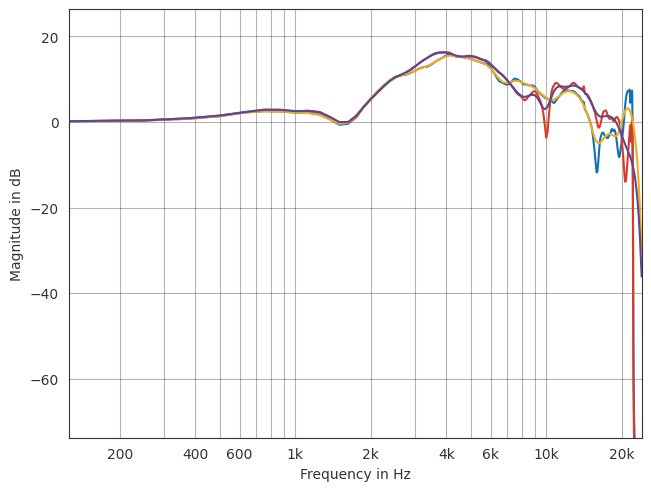

In [111]:
pf.plot.freq(sig[onax_idx])
pf.plot.freq(onax_smoothed)

In [1]:
0.1 * 10 ** (-10 / 20 * 2)

0.010000000000000002

In [116]:
compensation = pf.dsp.regularized_spectrum_inversion(onax_smoothed, (0,0), regu_final=0.1 * 10 ** (-10 / 20 * 2)) # about 10 dB of max boost

freq domain energy Signal:
(2,) channels with 384 samples @ 48000.0 Hz sampling rate and none FFT normalization

(100, 25000.0)

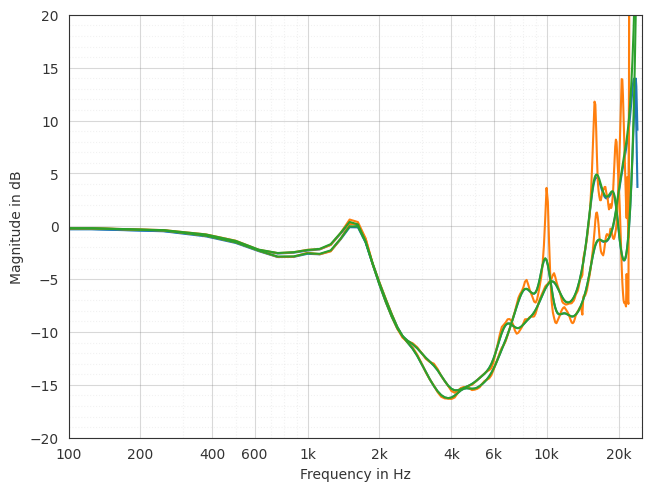

In [119]:
pf.plot.freq(compensation, color="tab:blue")
pf.plot.freq(1/sig[onax_idx], color="tab:orange")
pf.plot.freq(1/onax_smoothed, color="tab:green")
mygrid()
ylim(-20, 20)
xlim(100, 25e3)

In [120]:
sig_normalized = sig * compensation

freq domain energy Signal:
(64800, 2) channels with 384 samples @ 48000.0 Hz sampling rate and none FFT normalization

In [123]:
s.SourcePosition[7_000]

array([160.,  71.,   1.])

<Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>

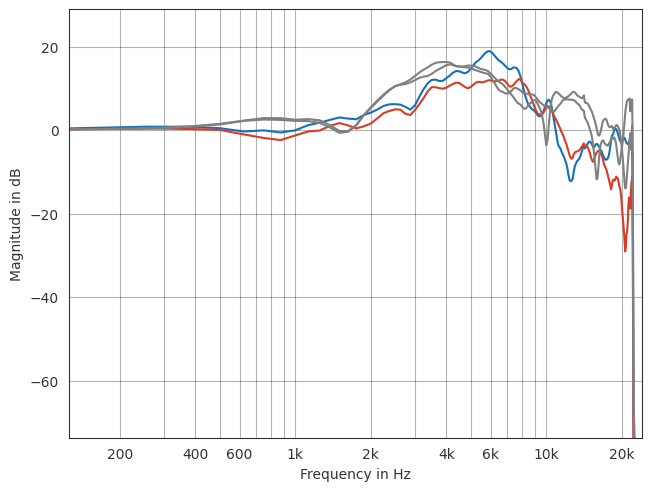

In [121]:
pf.plot.freq(sig[7_000])
pf.plot.freq(sig[onax_idx], color="grey")

<Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>

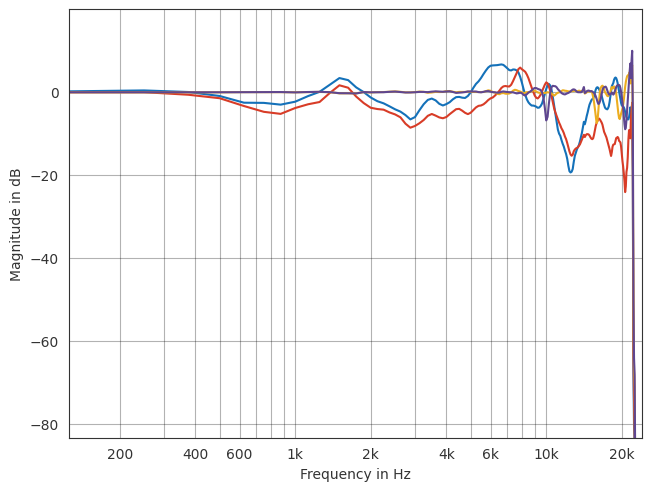

In [122]:
pf.plot.freq(sig_normalized[7_000])
pf.plot.freq(sig_normalized[onax_idx])

<Axes: xlabel='Time in s', ylabel='Amplitude'>

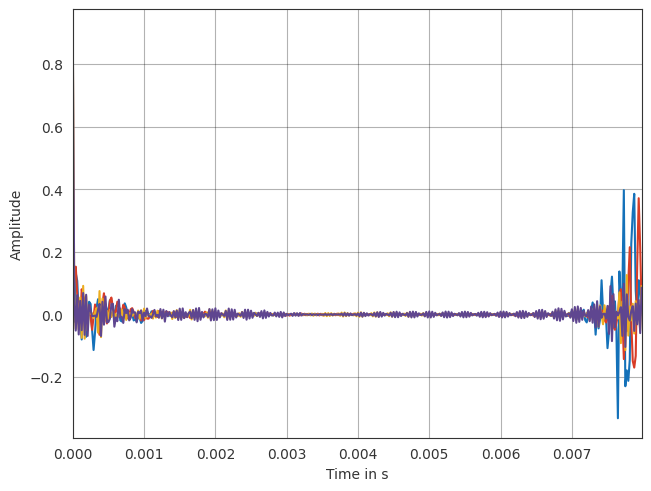

In [124]:
pf.plot.time(sig_normalized[7_000])
pf.plot.time(sig_normalized[onax_idx])

Seems good. There are now some spikes around onax but these were in there before as well and at least they won't show up in other directions if we apply the smoothing before inversion.

In [150]:
d = s.copy()

sofar.SOFA object: SimpleFreeFieldHRIR 1.0

In [151]:
assert d.Data_IR.shape == sig_normalized.time.shape

In [152]:
d.Data_IR = sig_normalized.time

In [153]:
d.GLOBAL_History += "\n J. Fried: Normalize to smoothed, regularized on-axis responses"

In [157]:
d.GLOBAL_RoomType = "free field"

In [162]:
d.GLOBAL_DateModified = "2024-06-19"

In [158]:
d.inspect()

SimpleFreeFieldHRIR 1.0 (SOFA version 2.0)
-------------------------------------------
GLOBAL_Conventions : SOFA
GLOBAL_Version : 2.0
GLOBAL_SOFAConventions : SimpleFreeFieldHRIR
GLOBAL_SOFAConventionsVersion : 1.0
GLOBAL_APIName : ARI SOFA API for Matlab/Octave
GLOBAL_APIVersion : 2.0
GLOBAL_ApplicationName : ITA-Toolbox
GLOBAL_ApplicationVersion : 9
GLOBAL_AuthorContact : Hark Braren (@)
GLOBAL_Comment : 
GLOBAL_DataType : FIR
GLOBAL_History : H. Braren and J. Fels: A High-Resolution Head-Related Transfer Function Data Set and 3D-Scan of KEMAR
 J. Fried: Normalize to smoothed, regularized on-axis responses
GLOBAL_License : Creative Commons Attribution 4.0 (CC BY 4.0)
GLOBAL_Organization : Institute of Technical Acoustics, RWTH Aachen University
GLOBAL_References : H. Braren and J. Fels: A High-Resolution Head-Related Transfer Function Data Set and 3D-Scan of KEMAR
GLOBAL_RoomType : free field
GLOBAL_Origin : 
GLOBAL_DateCreated : 14-Oct-2020
GLOBAL_DateModified : 2020-12-10 13:59:42


In [175]:
d.get_dimension("M")

64800

In [166]:
d.Data_IR.dtype

dtype('float64')

In [193]:
sofar.write_sofa("../data/processed/RWTH-2020-11307/Kemar_HRTF_sofa-onax_normalized.sofa", d, 1)

## Just me trying to test out why my file is so big...

Compression in Python seems much worse (~ 1.1) than what the original authors could do (~2.1). Well...